# 스팀 리뷰 보기
- 게임의 리뷰 텍스트 데이터를 살펴보면 피드백을 얻고 개선점을 찾을 수 있을 것임
- 긍정 리뷰, 부정 리뷰로 나눠서 살펴보겠음

In [236]:
from konlpy.tag import *
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import mysql_info
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

MYSQL_HOST = mysql_info.host
MYSQL_USER = mysql_info.user
MYSQL_PW = mysql_info.password
MYSQL_PORT = 3306

MYSQL_DB = mysql_info.db
MYSQL_DB_RAW = mysql_info.db_raw

nltk.download('punkt') # 토큰화
nltk.download('stopwords') # 불용어
nltk.download('wordnet') # Lemmatization : 표제어 추출
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dowra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dowra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dowra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dowra\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [237]:
# 버전 체크
nltk.__version__

'3.7'

In [238]:
def get_engine(host = MYSQL_HOST,
                user = MYSQL_USER,
                password = MYSQL_PW,
               port = MYSQL_PORT,
                db = None):
    
    """sqlalchemy을 이용해 create_engine.connect() 객체를 반환"""
    
    if db == None:
        db_connection_str = f'mysql+pymysql://{user}:{password}@{host}:{port}/'
    else:
        db_connection_str = f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'
    
    engine = create_engine(db_connection_str, encoding = 'utf-8')    
    return engine

def reviews_to_df(conn_raw, appid = None, language = 'koreana'):
    """
    `appid`와 `langauge`를 입력으로 받아 리뷰 데이터프레임을 반환함
    langauge 종류 : english, japanese, koreana
    """
    
    if appid == None:
        print("appid를 입력해주세요")
        return

    q = f"SELECT * FROM raw_review WHERE appid = {appid} AND language = '{language}'"
    df = pd.read_sql(q, conn_raw)

    return df
    
def get_appid(conn, name = None):
    """
    name을 받아 appid를 반환함  
    중복이 있는 경우가 있는데 일단 보류
    """
    if name == None:
        print('name 입력이 필요')
        return
    
    q = f"SELECT appid FROM info WHERE name = '{name}'" # ''이 없으면 name = DAVE THE DIVER라서 오류
    temp = pd.read_sql(q, conn)
    appid = temp.loc[0, 'appid']
    
    return appid

## 최근에 핫했던 DAVE THE DIVER를 보자

In [239]:
%%time
engine = get_engine(db = MYSQL_DB)
engine_raw = get_engine(db = MYSQL_DB_RAW)

conn = engine.connect()
conn_raw = engine_raw.connect()

appid = get_appid(conn, 'DAVE THE DIVER')
EnglishDf = reviews_to_df(conn_raw, appid = appid, language = 'english')
KoreanDf = reviews_to_df(conn_raw, appid = appid, language = 'koreana')
JapaneseDf = reviews_to_df(conn_raw, appid = appid, language = 'japanese')

Wall time: 1min 3s


In [240]:
# 전처리

# 날짜 데이터 : Object -> datetime
EnglishDf['review_date'] = pd.to_datetime(EnglishDf['review_date'])
KoreanDf['review_date'] = pd.to_datetime(KoreanDf['review_date'])
JapaneseDf['review_date'] = pd.to_datetime(JapaneseDf['review_date'])

# 리뷰 데이터 소문자화
EnglishDf['review'] = EnglishDf['review'].apply(lambda x : x.lower())

# 원하는 문자만 남기고 모두 제거
p_eng = re.compile("[^a-zA-Z0-9\s']")
EnglishDf['review'] = EnglishDf['review'].apply(lambda x : re.sub(p_eng, '', x))

# 특수문자 제거
p_kor = re.compile('[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]')
KoreanDf['review'] = KoreanDf['review'].apply(lambda x : re.sub(p_kor, '', x))


In [241]:
# print(EnglishDf.shape) # 1862
# print(KoreanDf.shape) # 651
# print(JapaneseDf.shape) # 135

### 1. 언어 별 날짜에 따른 긍정/부정 리뷰 추이

Text(0.5, 0, '')

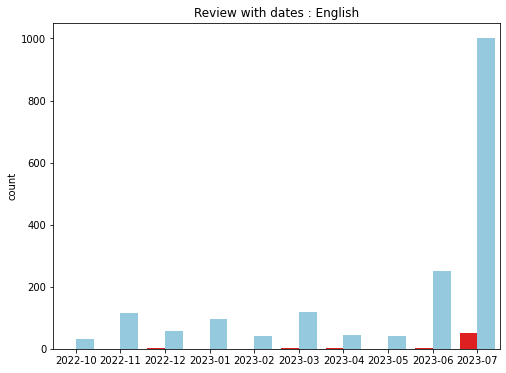

In [242]:
EnglishDf['month'] = EnglishDf['review_date'].dt.to_period('M')

plt.figure(figsize = (8, 6))
sns.countplot(x = EnglishDf['month'].sort_values(ascending = True),
             hue = EnglishDf['recommend'],
             palette = ['red', 'skyblue'])
plt.title("Review with dates : English")
plt.legend().set_visible(False)

plt.xlabel('')

Text(0.5, 0, '')

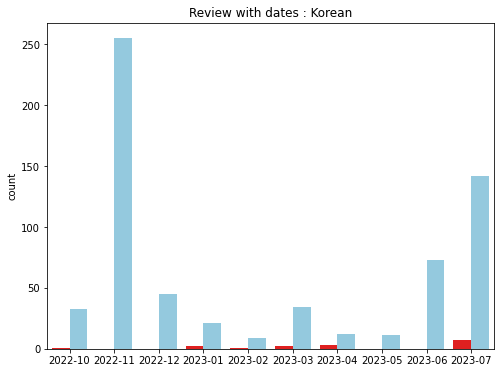

In [243]:
KoreanDf['month'] = KoreanDf['review_date'].dt.to_period('M')

plt.figure(figsize = (8, 6))
sns.countplot(x = KoreanDf['month'].sort_values(ascending = True),
             hue = KoreanDf['recommend'],
             palette = ['red', 'skyblue'])
plt.title("Review with dates : Korean")
plt.legend().set_visible(False)
plt.xlabel('')

Text(0.5, 0, '')

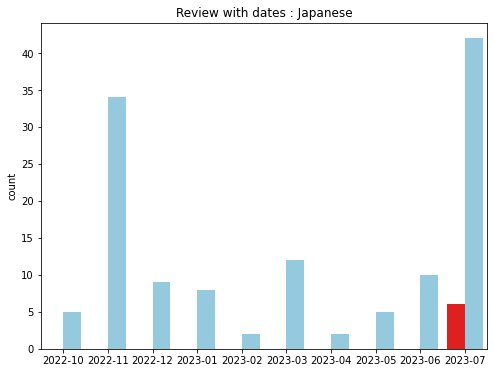

In [244]:
JapaneseDf['month'] = JapaneseDf['review_date'].dt.to_period('M')

plt.figure(figsize = (8, 6))
sns.countplot(x = JapaneseDf['month'].sort_values(ascending = True),
             hue = JapaneseDf['recommend'],
             palette = ['red', 'skyblue'])
plt.title("Review with dates : Japanese")
plt.legend().set_visible(False)
plt.xlabel('')

### 2. 긍/부정 리뷰 분석(영어, 한국어)

#### 1. 영어 리뷰 분석

In [258]:
eng_positive = EnglishDf[EnglishDf['recommend'] == 1][:] # 1799개
eng_negative = EnglishDf[EnglishDf['recommend'] == 0][:] # 63개

In [297]:
# 위 내용 함수로 만듦 : 영어용인 것에 주의
def get_word_freq(reviews, N = 30):
    """
    series는 iterable 객체가 오면 될 듯? \
    일단 list, Series만 온다고 가정하고 진행함 \
    N은 표시할 단어 갯수
    """
    
    if type(reviews) == pd.core.series.Series:
        reviews = reviews.values
    else:
        print(type(reviews))
        
    
    # 표제어 추출
    lemmatizer = WordNetLemmatizer() 
    
    # 불용어 사전
    stop_words = set(stopwords.words('english'))
    add_lst = ['game', 'play']
    stop_words.update(add_lst)
    
    
    entire_lst = []

    for i in reviews:
        # word 토큰화
        tokenized = word_tokenize(i)
        tokenized = list(map(lambda x : lemmatizer.lemmatize(x, pos = wordnet.VERB), tokenized))
        entire_lst.extend(tokenized)
        
    result = [i for i in entire_lst if i not in stop_words]
    
    # 단어 등장 빈도수
    word_freq = nltk.FreqDist(result)
    
    # 슬라이싱 : dict를 슬라이싱이 가능한 형태로 바꾼 다음 다시 되돌림
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:N])
    
    return word_freq
    

def get_wordcloud(wordfreq: dict, pos = True):
    
    palette = ['Blues', 'Reds']
    
    if pos:
        color = palette[0]
    else:
        color = palette[1]
    wordcloud = (WordCloud(width=800, 
                       height=400, 
                       background_color='white',
                          colormap = color).generate_from_frequencies(wordfreq)
            )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

<class 'numpy.ndarray'>


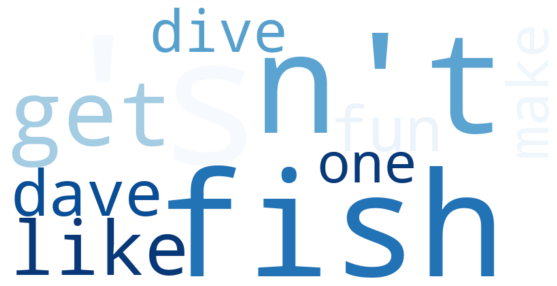

In [298]:
# 긍정 리뷰의 내용만 추출
pos_review = eng_positive['review'].values

# 함수 실행
word_freq = get_word_freq(pos_review, 10)
get_wordcloud(word_freq)

- `wordcloud`로만 보면 이런 결과인데, 조금 더 들여다보자
- 각 리뷰는 `좋아요` 기능이 있다. 이 갯수가 `get_voted_helpful`, `get_voted_funny`로 나타나 있는데, 이를 내림차순으로 살펴보자

In [301]:
eng_positive = eng_positive.sort_values(by = ['get_voted_helpful', 'get_voted_funny'], 
                        ascending = False)
target_df = eng_positive.loc[:, ['id', 'recommend', 'get_voted_helpful', 'get_voted_funny', 'weighted_vote_score', 'review_date', 'review']]
target_df

,id,recommend,get_voted_helpful,get_voted_funny,weighted_vote_score,review_date,review
630,140859659,1,5022,927,0.9692,2023-06-28,you know how sometimes you're with the lads th...
664,140875925,1,3518,4463,0.9012,2023-06-28,imagine paying 250k to see the bottom of the o...
583,139575465,1,1311,2906,0.9536,2023-06-05,wonderful game i just wish they had asked befo...
599,140299096,1,1027,329,0.8372,2023-06-18,im surprised devolver digital didn't get hold ...
711,140892141,1,993,217,0.9471,2023-06-29,i stopped playing zelda to play this
...,...,...,...,...,...,...,...
1858,142248522,1,1,0,0.5238,2023-07-17,finally a protagonist that i feel represents me
1859,142249945,1,1,0,0.5238,2023-07-17,easy goty contender stardew valley of the sea ...
1861,142256479,1,1,0,0.5238,2023-07-17,fish
1170,141361150,1,0,4,0.5238,2023-07-05,this game is addictive i once dreamed about th...


In [300]:
for i in target_df['review'].values[:10]:
    print(i)

you know how sometimes you're with the lads then you tell them you're off to bed but you're actually playing that singleplayer game you're addicted to this is that game
imagine paying 250k to see the bottom of the ocean when instead you could of just bought this
wonderful game i just wish they had asked before using me as a reference photo for the main character
im surprised devolver digital didn't get hold of this one first delightful game okay fine i haven't played it my partner actually racked up the hours on this whilst im playing totk here's her review as a new gamer  i can choose to avoid fighting if it's too hard  i like finding new fish  sushi store is a welcome break and nice little minigame  upgrading my equipment feels cool  jellyfish suck  babe i killed that fucking shark ahahaha
i stopped playing zelda to play this
a better value then oceangate tickets
didn't pay 250k for ocean exploration and even have a sushi restaurant  1110 would recommend
as a very very picky gamer da

- 스팀은 "웃겨요" 버튼과 "도움이 됐어요" 버튼을 구분했지만, 혼용된 느낌이 있다.

<class 'numpy.ndarray'>


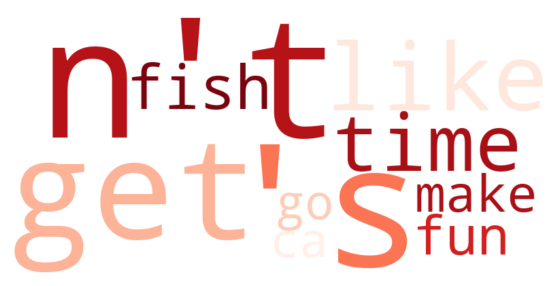

In [302]:
# 부정 리뷰의 내용만 추출
neg_review = eng_negative['review'].values

# 함수 실행
word_freq = get_word_freq(neg_review, 10)
get_wordcloud(word_freq, pos = False)

In [255]:
eng_negative = eng_negative.sort_values(by = ['get_voted_helpful', 'get_voted_funny'], 
                        ascending = False)

for i in target_df['review'].values[:10]:
    print(i)

{"'s": 101, "n't": 96, 'get': 78, 'like': 71, 'time': 70, 'fish': 59, 'fun': 44, 'make': 41, 'go': 37, 'ca': 37, 'one': 36, 'feel': 32, 'part': 31, 'upgrade': 31, 'hours': 28, 'lot': 28, 'try': 28, 'dive': 27, 'also': 27, "'m": 26, 'things': 25, 'button': 25, 'every': 25, 'review': 25, 'dave': 25, 'people': 24, 'many': 23, 'day': 23, 'restaurant': 23, 'even': 23}


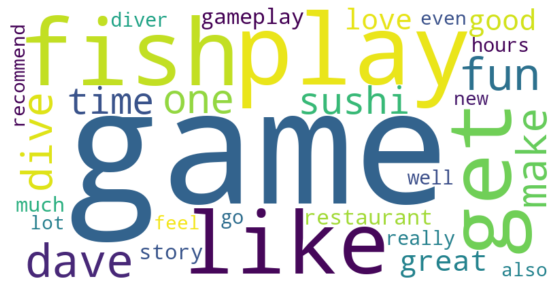

In [164]:
# 시각화

wordcloud = (WordCloud(width=800, 
                       height=400, 
                       background_color='white').generate_from_frequencies(sorted_dict)
            )

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2. 한국어 리뷰 분석

In [ ]:
KoreanDf['length'] = KoreanDf['review'].apply(lambda x : len(x))
KoreanDf.groupby('recommend')['length'].mean().plot(kind = 'bar', color = ['red', 'skyblue'])
plt.title("text number by recommend")

In [3]:
engine = get_engine(db = MYSQL_DB)
conn = engine.connect()
engine_raw = get_engine(db = MYSQL_DB_RAW)
conn_raw = engine_raw.connect()

q = "SELECT appid, name FROM info"
temp = pd.read_sql(q, conn)

# DAVE THE DIVER를 알아보자
target_appid = temp[temp['name'] == 'DAVE THE DIVER']['appid'].values[0]

q = f"SELECT * FROM raw_review WHERE appid = {target_appid}"
df = pd.read_sql(q, conn_raw)

df = df[['id', 'review', 'recommend', 'playtime_forever', 'review_date']]
df['review_length'] = df['review'].apply(lambda x : len(x))

In [5]:
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
# mecab = Mecab() # 윈도우에서 실행 불가능이라는 듯
okt = Okt()

examples = df.loc[:, 'review']

In [ ]:
%%time

han_lst = []
kkm_lst = []
kom_lst = []
okt_lst = []


# lst.extend : 현재 리스트에 다른 리스트의 원소들을 추가함
for example in examples:
    
    # okt가 8000자를 만나니까 아예 이상이 생겨서 넣어봄
    if len(example) >= 4000:
        example = example[:2000]
    
    # 공백을 제외한 특수문자 제거
    p = re.compile('[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]')
    example = re.sub(p, '', example)
    
    han_morph = hannanum.morphs(example)
    kkm_morph = kkma.morphs(example)
    kom_morph = komoran.morphs(example)
    okt_morph = okt.morphs(example)
    
    # 한 명이 쓴 리뷰에서, 같은 단어가 여러 번 나오더라도 1개만 카운트함
    han_morph = list(set(han_morph))
    kkm_morph = list(set(kkm_morph))
    kom_morph = list(set(kom_morph))
    okt_morph = list(set(okt_morph))
    
    # 1글자는 일반적으로 형태소나 의미 없는 조사인 경우가 많아서 제외해봄
    han_result = [i for i in han_morph if len(i) >= 2]
    kkm_result = [i for i in kkm_morph if len(i) >= 2]
    kom_result = [i for i in kom_morph if len(i) >= 2]
    okt_result = [i for i in okt_morph if len(i) >= 2]
    
    han_lst.extend(han_result)
    kkm_lst.extend(kkm_result)
    kom_lst.extend(kom_result)
    okt_lst.extend(okt_result)
    
    
han_count = Counter(han_lst)
kkm_count = Counter(kkm_lst)
kom_count = Counter(kom_lst)
okt_count = Counter(okt_lst)


In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))


for i, lst in enumerate([han_count, kkm_count, kom_count, okt_count]):
    for j in range(2):
        wc = WordCloud(font_path='malgun', 
                       width=400, 
                       height=400, 
                       scale=2.0, 
                       max_font_size=250,
                      background_color = 'white')
        
        img = wc.generate_from_frequencies(lst)
        ax[i // 2][j].imshow(img)
        ax[i // 2][j].set_axis_off()

plt.show()

Text(0.5, 1.0, 'text number by recommend')

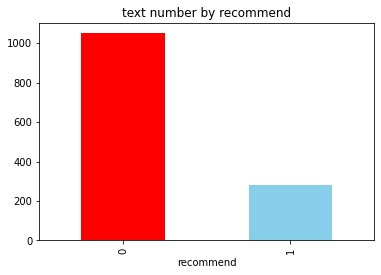

In [140]:
# 재미로 보는 리뷰 글자 수
EnglishDf['length'] = EnglishDf['review'].apply(lambda x : len(x))
EnglishDf.groupby('recommend')['length'].mean().plot(kind = 'bar', color = ['red', 'skyblue'])
plt.title("text number by recommend")

In [ ]:
conn.close()
conn_raw.close()
engine.dispose()
engine_raw.dispose()